## ECMM 409 Nature Inspired Computation
### CA2 Coursework Code - Eta Team

Candidate Numbers:
- 077832
- 019740
- 046781
- 047467
- 036414

## Import packages

In [1]:
import pandas as pd
import numpy as np

# using matplotlib to plot
import matplotlib.pyplot as plt
%matplotlib inline

# using svg format to get best image quality on notebook 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# to calculate and display confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# precision, recall, f1-score and support
from sklearn.metrics import classification_report
# kappa score, f1 score
from sklearn.metrics import cohen_kappa_score, f1_score, log_loss

from tqdm import tqdm

# ------ used in LSTM model ------ 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

## Define function that loads the dataset

In [20]:
def load_data():
    # read training dataset
    training = pd.read_csv('Training.csv', parse_dates=True)
    # remove unnamed columns
    training = training.loc[:, ~training.columns.str.contains('^Unnamed')]
    # set time column as index
    training['Time'] = pd.DatetimeIndex(training['Time'])
    training = training.set_index('Time')
    
    # read test dataset
    test = pd.read_csv('Testing.csv', index_col=1, parse_dates=True)
    # remove unnamed columns
    test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
    
    # fill na with 0
    training = training.fillna(0)
    test = test.fillna(0)
    
    # print correlations
    print(training.dropna().corr())

    # extract features
    X_train = training.drop('EVENT', axis=1)
    X_test=test.drop('EVENT', axis=1)
    # extract target
    Y_train = training['EVENT']
    Y_test=test['EVENT']
    
    # convert to numpy array
    X_train = X_train.to_numpy().astype(np.float32)
    Y_train = Y_train.to_numpy().astype(np.int8)

    X_test = X_test.to_numpy().astype(np.float32)
    Y_test = Y_test.to_numpy().astype(np.int8)
    
    return X_train, Y_train, X_test, Y_test

## Define function that plots the confusion matrix and print metrics

In [3]:
def plot_cm(y_true, y_pred, save_as=None):
    """
    Plot confusion matrix
    @param y_true, np.array, true labels
    @param y_pred, np.array, predicted labels
    @param display_labels, np.array, display labels on axis
    """
    # calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # initialize ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # prepare figure
    fig = plt.figure(figsize=(5, 5))
    # get current axis
    ax = fig.gca()
    # plot
    disp = disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)
    # set title and save to file
    ax.set_title('Water Quality Anomaly Detection')
    if save_as is not None:
        plt.savefig(save_as, format='pdf', bbox_inches='tight')
    
    # print report of precision, recall, f1-score and support
    print(classification_report(y_true, y_pred))
    
    # print kappa value
    kappa_value = cohen_kappa_score(y_true, y_pred)
    print("kappa = %f" % kappa_value)
    
    # The micro F1-score, macro F1-score and weighted F1-score
    print('Micro F1-score = %.5f' % f1_score(y_true, y_pred, average='micro'))
    print('Macro F1-score = %.5f' % f1_score(y_true, y_pred, average='macro'))
    print('Weighted F1-score = %.5f' % f1_score(y_true, y_pred, average='weighted'))

## Load train and test data

In [4]:
# load data
X_train, Y_train, X_test, Y_test = load_data()

             Tp        Cl        pH     Redox      Leit     Trueb      Cl_2  \
Tp     1.000000  0.948835  0.955430  0.944517  0.898868  0.528958  0.846250   
Cl     0.948835  1.000000  0.979352  0.973239  0.948435  0.516091  0.914480   
pH     0.955430  0.979352  1.000000  0.996609  0.968113  0.517524  0.934406   
Redox  0.944517  0.973239  0.996609  1.000000  0.962424  0.507129  0.941441   
Leit   0.898868  0.948435  0.968113  0.962424  1.000000  0.499167  0.940569   
Trueb  0.528958  0.516091  0.517524  0.507129  0.499167  1.000000  0.426762   
Cl_2   0.846250  0.914480  0.934406  0.941441  0.940569  0.426762  1.000000   
Fm     0.938023  0.942390  0.949047  0.943918  0.905861  0.516625  0.883320   
Fm_2   0.923177  0.926439  0.940577  0.936754  0.902853  0.478794  0.877864   
EVENT  0.041486  0.035915  0.013507  0.000045  0.001309  0.130144 -0.023766   

             Fm      Fm_2     EVENT  
Tp     0.938023  0.923177  0.041486  
Cl     0.942390  0.926439  0.035915  
pH     0.949047 

## Define function that plot abnormal events temporally and invoke it

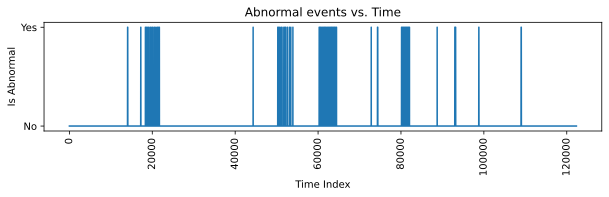

In [21]:
def plot_abnormal_event_temporally(events):
    plt.figure(figsize=(10, 2))
    plt.plot(events)
    ax = plt.gca()
    plt.xticks(rotation=90)
    plt.ylabel('Is Abnormal')
    plt.yticks([0, 1], ['No', 'Yes'])
    plt.xlabel('Time Index')
    plt.title('Abnormal events vs. Time')
    plt.savefig('abnormal_events.pdf', format='pdf', bbox_inches='tight')

plot_abnormal_event_temporally(Y_train)

## Define function that plot data distribution and plot the distribution of temperature feature

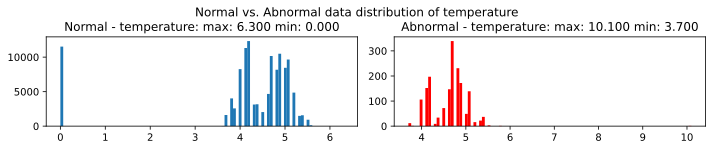

In [6]:
def plot_data_distribution(X, Y, feature_index):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        labels = ['temperature', 'Chlorine dioxide', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'flow rate 1', 'flow rate 2']
        feature_name = labels[feature_index]
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10, 2))
        ax[0].hist(X[Y==False, feature_index], bins=100)
        ax[1].hist(X[Y==True, feature_index], color = "red", bins=100)
        ax[0].set_title(f"Normal - {feature_name}: max: {X[Y==False, feature_index].max():.03f} min: {X[Y==False, feature_index].min():.03f}")
        ax[1].set_title(f"Abnormal - {feature_name}: max: {X[Y==True, feature_index].max():.03f} min: {X[Y==True, feature_index].min():.03f}")
        fig.tight_layout()
        fig.suptitle(f'Normal vs. Abnormal data distribution of {feature_name}',y=1.02)
        plt.savefig('distribution.pdf', format='pdf', bbox_inches='tight')

plot_data_distribution(X_train, Y_train, 0)

## Define LSTM model and experiment code for LSTM

In [7]:
def get_lstm_model(shape):
    model = Sequential([Input(shape=shape)])
    model.add(Bidirectional(LSTM(8, return_sequences=True)))
    model.add(LSTM(8))
    model.add(Dense(1, activation='sigmoid'))

    # compile model with default Adam optimizer and using binary crossentropy as loss function
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def lstm_approach(X_train, Y_train, X_test, Y_test, time_steps, batch_size):
    # get LSTM model with given time_steps
    model = get_lstm_model((time_steps, X_train.shape[1],))
    
    # instantiate a time series generator with given time steps
    timeseries_gen = TimeseriesGenerator(X_train, Y_train, length=time_steps, batch_size=batch_size)
    
    # fit the LSTM model
    history = model.fit(timeseries_gen, epochs=50, batch_size=batch_size, verbose=2)
    
    # evaluate fitness
    timeseries_gen_test = TimeseriesGenerator(X_test, Y_test, length=time_steps, batch_size=batch_size)
    y_pred = model.predict(timeseries_gen_test)

    # convert continous data to 0 or 1
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    
    # plot confusion matrix
    plot_cm(Y_test[time_steps:], y_pred, 'lstm-cm.pdf')
    
    # plot model graph
    # Noticing, you will need to install graphviz in your system to plot the model in PDF
    # If you have the graphviz package installed, you can uncomment the following line
    # plot_model(model, to_file='lstm-model.pdf', show_shapes=True)

    # plot training loss
    plt.figure(figsize=(5, 5))
    plt.plot(history.history['loss'])
    plt.title('LSTM - Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training'], loc='upper right')
    plt.savefig('lstm-loss.pdf', format='pdf', bbox_inches='tight')
    return model, history

## Reset the seed random number generators and do the LSTM experiment

Epoch 1/50
239/239 - 7s - loss: 0.2267
Epoch 2/50
239/239 - 5s - loss: 0.0829
Epoch 3/50
239/239 - 5s - loss: 0.0759
Epoch 4/50
239/239 - 5s - loss: 0.0760
Epoch 5/50
239/239 - 5s - loss: 0.0743
Epoch 6/50
239/239 - 5s - loss: 0.0742
Epoch 7/50
239/239 - 5s - loss: 0.0739
Epoch 8/50
239/239 - 5s - loss: 0.0735
Epoch 9/50
239/239 - 5s - loss: 0.0726
Epoch 10/50
239/239 - 5s - loss: 0.0738
Epoch 11/50
239/239 - 5s - loss: 0.0737
Epoch 12/50
239/239 - 5s - loss: 0.0736
Epoch 13/50
239/239 - 5s - loss: 0.0737
Epoch 14/50
239/239 - 5s - loss: 0.0736
Epoch 15/50
239/239 - 5s - loss: 0.0736
Epoch 16/50
239/239 - 5s - loss: 0.0735
Epoch 17/50
239/239 - 5s - loss: 0.0738
Epoch 18/50
239/239 - 5s - loss: 0.0736
Epoch 19/50
239/239 - 5s - loss: 0.0736
Epoch 20/50
239/239 - 5s - loss: 0.0735
Epoch 21/50
239/239 - 5s - loss: 0.0735
Epoch 22/50
239/239 - 5s - loss: 0.0734
Epoch 23/50
239/239 - 5s - loss: 0.0734
Epoch 24/50
239/239 - 5s - loss: 0.0780
Epoch 25/50
239/239 - 5s - loss: 0.0742
Epoch 26/

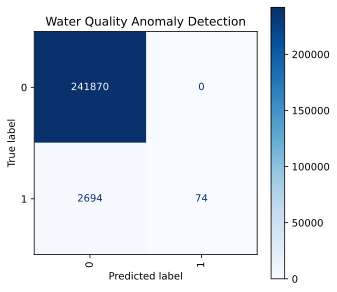

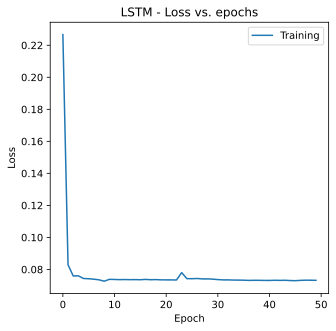

In [8]:
# Reset the seed random number generators so that the result can be reproduced
np.random.seed(42)
tf.random.set_seed(42)

# set time steps to 30 and batch size to 512 samples
time_steps = 30
batch_size = 512
model, history = lstm_approach(X_train, Y_train, X_test, Y_test, time_steps, batch_size)

## The final selected approach
Inspired by human immune system, artitificial immune system and probabilistics model

In [14]:
class WaterQuality(object):
    def __init__(self, feature_ranges, num_cells = 1000, seed = 42, death_rate=0.2, max_tolerance=4, extinct_rate=0.9):
        # min and max ranges, number of subranges
        self.feature_ranges = feature_ranges
        
        # generate subranges for each frature
        self.feature_subranges = []
        for feature_range in self.feature_ranges:
            self.feature_subranges.append(np.linspace(start=feature_range[0], 
                                                      stop=feature_range[1], 
                                                      num=feature_range[2]))
        self.feature_subranges = np.array(self.feature_subranges)
        
        # the number of cells to simulate
        # default value is 1000
        self.num_cells = num_cells
        
        # the sensetivity of these cells
        # 3 dimension array: [feature_index, cell_index, subrange_index]
        self.sensetivity = []
        
        # initialise random number generator with seed
        self.rng = np.random.default_rng(seed=seed)
        
        # assign given death rate
        # default value is 0.2
        self.death_rate = death_rate
        
        # cell will die if `max_tolerance` features exceeds their threshold
        # default value is 4
        self.max_tolerance = max_tolerance
        
        # if the ratio between the dead cells and total number of cells
        # exceeds this rate, then the group of cells is considered as extinct
        # default value is 0.9
        self.extinct_rate = extinct_rate
    
    def generate_random_solution(self):
        """
        generate the random initial solution
        """
        self.sensetivity = []
        for feature in self.feature_ranges:
            # the threshold values are generated by uniform distribution U(0, 1)
            # for each cell and each feature subrange
            self.sensetivity.append(self.rng.uniform(low=0, high=1, size=(self.num_cells, feature[2])))
    
    def trial(self, ind, sample, is_training=False, y_true=None):
        """
        this function accepts one sample and do the trial
        """
        deads = np.array([])
        # iterate through the features of given sample
        for feature_idx, val in enumerate(sample):
            # find the minimal subrange index of this featue value
            min_ind = np.argmin(val > self.feature_subranges[feature_idx])
            # get the sensetivity for all cells of this feature at subrange `min_ind`
            cur_sensetivity = self.sensetivity[feature_idx][:, min_ind]
            
            # training stage
            if is_training:
                if y_true == True:
                    # Abnormal
                    if (feature_idx not in (0,5,7)):
                        # negative correlations
                        response_to_env = cur_sensetivity < self.death_rate
                    else:
                        # positive correlation to event
                        response_to_env = cur_sensetivity > self.death_rate
                    
                    # indices where cells are dead
                    dead = np.where(response_to_env)[0]
                    # add indices to deads
                    deads = np.concatenate((deads, dead), axis=0)
                    # number of deads
                    num_dead = dead.shape[0]
                    # select 50% cells that will gain immunity
                    gain_immunity = dead[self.rng.choice(num_dead, int(num_dead * 0.5), replace=False)]
                    # remaining cells will lose immunity due to abnormality
                    lose_immunity = list(set(range(self.num_cells)) - set(gain_immunity))
                    # 10% to left and right of the val
                    min_ind_l = np.argmin(val*0.9 > self.feature_subranges[feature_idx])
                    min_ind_r = np.argmin(val*1.1 > self.feature_subranges[feature_idx])
                    # 50% of dead cells having val 10% around the given value will gain 1% immunity
                    self.sensetivity[feature_idx][gain_immunity, min_ind_l:min_ind_r] *= 1.01
                    # remaining cells will loss 25% immunity around the given value
                    self.sensetivity[feature_idx][lose_immunity, min_ind_l:min_ind_r] *= 0.75
                else:
                    # Normal
                    # 5% to left n right of val
                    min_ind_l = np.argmin(val*0.95 > self.feature_subranges[feature_idx])
                    min_ind_r = np.argmin(val*1.05 > self.feature_subranges[feature_idx])
                    # select 25% cells, that wil lose immunity
                    loss_immunity = self.rng.choice(self.num_cells, int(self.num_cells * 0.25), replace=False)
                    # remaining cells will gain immunity
                    gain_immunity = list(set(range(self.num_cells)) - set(loss_immunity))
                    # 25% of cells having value around 5% of the cell value will lose immunity of 1%
                    self.sensetivity[feature_idx][loss_immunity, min_ind_l:min_ind_r] *= 0.99
                    # remaing cells will gain confidence sue to normality
                    self.sensetivity[feature_idx][gain_immunity, min_ind_l:min_ind_r] *=1.25
            else:
                # prediction stage
                if (feature_idx not in (0,5,7)):
                    # negative correlations
                    response_to_env = cur_sensetivity < self.death_rate
                else:
                    # positive correlation to event
                    response_to_env= cur_sensetivity > self.death_rate
                dead = np.where(response_to_env)[0]
                deads = np.concatenate((deads, dead), axis=0)

        # unique: 1d array that contains the indices of dead cells
        # counts: 1d array for how many features do the responding cell died from
        unique, counts = np.unique(deads, return_counts=True)
        # if there are dead cells
        if unique.shape[0] > 0:
            # then checking the number of cells died with `max_tolerance` features exceeds their threshold
            num_multiple_death_factors = np.sum(counts >= self.max_tolerance)
            # if the number of dead cells exceeds the number for they to extinct
            if num_multiple_death_factors > self.num_cells * self.extinct_rate:
                # then the sample will be classified as abnormal
                return 1
        # otherwise normal
        return 0

    
    def fit(self, X, Y):
        """
        fit the data
        @param X, np.array, training data
        @param Y, np.array, training target
        @return y_pred, np.array, classified labels for each training sample during training stage
        """
        # generate random solution first
        self.generate_random_solution()
        
        # then do the trials for each training sample
        y_pred = np.zeros((X.shape[0]))
        for ind, sample in tqdm(enumerate(X)):
            y_pred[ind] = self.trial(ind, sample, is_training=True, y_true=Y[ind])
        return y_pred

    def pred(self, X):
        """
        predict the input samples
        @param X, np.array, input data
        @return y_pred, np.array, classified labels for each input sample
        """
        y_pred = np.zeros((X.shape[0]))
        for ind, sample in tqdm(enumerate(X)):
            y_pred[ind] = self.trial(ind, sample)
        return y_pred


## Set predefined min and max value for each feature and their number of subranges

In [15]:
feature_ranges = np.array([
    # [min, max, number of subranges]
    [-10, 100, 180],    # tempreature
    [0, 1, 75],         # Chlorine dioxide
    [0, 14, 150],       # PH
    [0, 2000, 300],     # Redox
    [0, 5000, 2500],    # Leit
    [0, 1, 75],         # Trueb
    [0, 1, 75],         # Cl_2
    [0, 5000, 2500],    # Flow rate at water line 1
    [0, 5000, 2500],    # Flow rate at water line 2
])

## Initialse the WaterQuality class with predefined feature ranges

In [16]:
water = WaterQuality(feature_ranges)

/home/ryza/miniconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


## Fit the training data and print metrics like log loss and f1 score during training

In [17]:
y_pred = water.fit(X_train, Y_train)

print(f"training log_loss: {log_loss(Y_train, y_pred)}")
print(f"training f1: {f1_score(Y_train, y_pred)}")

4144it [00:09, 454.95it/s]/home/ryza/miniconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in multiply
13987it [00:30, 453.75it/s]/home/ryza/miniconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in multiply
122334it [04:28, 454.88it/s]

training log_loss: 0.30491832611133174
training f1: 0.5499999999999999


## Predict test data, plot confusion matrix and some metrics

244668it [00:42, 5693.33it/s]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    241900
           1       0.65      0.39      0.49      2768

    accuracy                           0.99    244668
   macro avg       0.82      0.69      0.74    244668
weighted avg       0.99      0.99      0.99    244668

kappa = 0.482609
Micro F1-score = 0.99074
Macro F1-score = 0.74115
Weighted F1-score = 0.98958


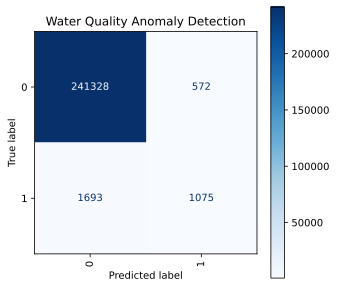

In [18]:
y_pred = water.pred(X_test)
plot_cm(Y_test, y_pred, 'ais-cm.pdf')

## Predict the training data
### Because the official result page only gave results on the training data, have to do this for comparison

122334it [00:19, 6342.45it/s]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00    120594
           1       0.87      0.47      0.61      1740

    accuracy                           0.99    122334
   macro avg       0.93      0.74      0.80    122334
weighted avg       0.99      0.99      0.99    122334

kappa = 0.607330
Micro F1-score = 0.99147
Macro F1-score = 0.80347
Weighted F1-score = 0.99022


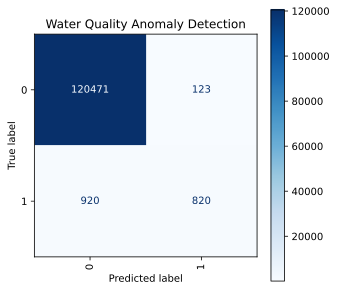

In [19]:
y_pred_train = water.pred(X_train)
plot_cm(Y_train, y_pred_train, 'ais-cm-train.pdf')